In [1]:
# import packages
import numpy as np
from aicsimageio import AICSImage
import torch as ch
from tqdm import tqdm
from os import path
import argparse
from distutils.util import strtobool
import os
import ast
import pandas as pd
from cellpose import models
import matplotlib.pyplot as plt
import seaborn as sns


from confocalQuant.segmentation import load_3D, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference,  sigmoid, gamma_correct_image, get_czi_files, toggle_filters
from confocalQuant.quantification import get_all_expectations
from confocalQuant.image import save_mean_proj
from confocalQuant.qc import get_metadata, return_non_unique_indices, print_metadata, return_channel_moments_per_im, get_day_and_time, plot_by, plot_hist, impose_segmentation_all
from confocalQuant.plotting import return_results

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [191]:
def extract_sbatch_parameters(file_path):
    parameters = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            # Ignore comments
            if line.startswith("#"):
                continue

            # Extract key-value pairs or parameters in list form
            parts = line.split()
            if len(parts) >= 2:
                key, *values = parts
                if '\\' in values:
                    # Handle parameters in the form of "--key value1 value2 \"
                    values = values[:values.index('\\')]
                parameters[key] = values
            elif len(parts) == 1:
                # Handle parameters in list form
                parameters.setdefault('list_parameters', []).extend(parts)

    return parameters

def return_results(path_to_sbatch_file, prefix):
    # get data and params
    params = extract_sbatch_parameters(path_to_sbatch_file)
    folder = params['--folder'][0][1:-1]
    NZi = int(params['--NZi'][0])
    xi_per_job = int(params['--xi_per_job'][0])
    yi_per_job = int(params['--yi_per_job'][0])
    cells_per_job = int(params['--cells_per_job'][0])
    Ncells = int(params['--Ncells'][0])
    Njobs = int(params['--Njobs'][0])
    channels = [int(x) for x in params['--channels']]
    mode = 'r'
    zi_per_job = int(params['--zi_per_job'][0])

    all_mat = np.lib.format.open_memmap(path.join(prefix + folder, 'mat.npy'), shape=(NZi, xi_per_job, yi_per_job, len(channels)), dtype=float, mode=mode)
    all_masks = np.lib.format.open_memmap(path.join(prefix + folder, 'masks.npy'), shape=(NZi, xi_per_job, yi_per_job), dtype='uint16', mode=mode)
    Nzi_per_job = np.lib.format.open_memmap(path.join(prefix + folder, 'Nzi_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)
    randID = np.lib.format.open_memmap(path.join(prefix + folder, 'randomID_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)

    probs = np.lib.format.open_memmap(path.join(prefix + folder, 'probs.npy'), shape=(Njobs,1), dtype=float, mode=mode)
    
    return all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID

import numba as nb
@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E, V, N):
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        #E_uniform[M] = np.mean(temp_vals)
        P = temp_probs/np.sum(temp_probs)
        E[M] = np.dot(temp_vals, P)
        V[M] = np.dot((np.power((temp_vals-E[M]),2)), P)/E[M]
        N[M] = np.sum(index)
        
def plot_hist(path, channel, nbins, scale_log, alpha, color, density):
    img = AICSImage(path)
    T = img.data[0,channel,:,:,:].ravel()
    T[T==0] = 1
    plt.hist(np.log(int_to_float(T)),nbins, alpha=alpha, color=color, density=density)
    None
    
    
   
def plot_treatments(df, x, line, colors, lognormal, binwidth,lab_height):
    sns.set(rc={'figure.figsize':(20,7)})
    sns.set_style("whitegrid")
    df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(3,5, sharex=True, gridspec_kw={"height_ratios": (1,.25,.5)})

    for i,t in enumerate(np.unique(df['treatment'])[:-1]):
        index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        # compute pvalue 
        text = compute_nested_anova(df_temp[index], x, 'treatment', 'well')
        sns.histplot(data=df_temp[index], x=x, ax=ax[0,i], hue='treatment', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
        ax[0,i].text(x=np.mean(df_temp[index][x]), y=lab_height, s=text, fontsize=12, color='black')
        
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
        sns.boxplot(data=df_temp[index], x=x, y='treatment',orient="h", ax=ax[1,i], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        sns.boxplot(data=df_temp[index], x=x, y='well',orient="h", ax=ax[2,i], width=.8, dodge=False, hue = 'treatment', palette = colors)#, order =(order))#, palette = colors)
        ax[2,i].get_legend().remove()
        ax[1,i].axes.get_yaxis().set_visible(False)


def plot_lines(df, x, treatment, colors, lognormal, binwidth):
    sns.set(rc={'figure.figsize':(6,12)})
    sns.set_style("whitegrid")
    df_temp = df[df['treatment']==treatment]

    if lognormal:
        df_temp[x] = np.log(df_temp[x])
        
    f, ax = plt.subplots(6, sharex=True, gridspec_kw={"height_ratios": (1,.5,1,1,.5,1)})

    index = df_temp['line']!='G2'
    # compute pvalue 
    text0 = compute_nested_anova(df_temp[index], x, 'line', 'well')
    
    sns.histplot(data=df_temp[index], x=x, ax=ax[0], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    ax[0].text(x=np.mean(df_temp[index][x])+2, y=.9, s=text0, fontsize=12, color='black')
    
    sns.boxplot(data=df_temp[index], x=x, y='line',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    sns.boxplot(data=df_temp[index], x=x, y='well',orient="h", ax=ax[2], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)

    index = df_temp['line']!='Y622'
    
    # compute pvalue 
    text1 = compute_nested_anova(df_temp[index], x, 'line', 'well')
    
    sns.histplot(data=df_temp[index], x=x, ax=ax[3], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    ax[3].text(x=np.mean(df_temp[index][x])+2, y=.9, s=text1, fontsize=12, color='black')

    sns.boxplot(data=df_temp[index], x=x, y='line',orient="h", ax=ax[4], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    sns.boxplot(data=df_temp[index], x=x, y='well',orient="h", ax=ax[5], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)
    
    for i in range(6):
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

def compute_nested_anova(resE, score, group, nested_col):
    # Fit a two-level ANOVA model
    model = mixedlm(score + '~' + group, resE, groups=resE[nested_col])
    result = model.fit()

    p = result.pvalues[1]
    
    p_scientific = "{:e}".format(p)

    coef = result.params[1]
    lower = result.conf_int().iloc[1][0]
    upper = result.conf_int().iloc[1][1]
    text0 = 'Coef: ' + str(np.round(coef,3)) + '\n95% CI: [' + str(np.round(lower,3)) + ',' + str(np.round(upper,3)) + '] \n' + 'p: ' + str(p_scientific)
    
    return text0   

In [3]:
from confocalQuant.plotting import get_out_files, is_string_present

# Do all the SBATCH files for the IDs we care about say done?

out_files = get_out_files('./outs/neuronbatch11082023_mitohealth_out/')
out_files = np.array(out_files)[np.argsort([int(x.split('_')[1].split('.')[0]) for x in out_files])]
res = []
for file in out_files:
    res.append((file, is_string_present('./outs/neuronbatch11082023_mitohealth_out/'+file, 'done')))
    
res

[('slurm-24523347_0.out', True),
 ('slurm-24523347_1.out', True),
 ('slurm-24523347_2.out', True),
 ('slurm-24523347_3.out', True),
 ('slurm-24523347_4.out', True),
 ('slurm-24523347_5.out', True),
 ('slurm-24523347_6.out', True),
 ('slurm-24523347_7.out', True),
 ('slurm-24523347_8.out', True),
 ('slurm-24523347_9.out', True),
 ('slurm-24523347_10.out', True),
 ('slurm-24523347_11.out', True),
 ('slurm-24523347_12.out', True),
 ('slurm-24523347_13.out', True),
 ('slurm-24523347_14.out', True),
 ('slurm-24523347_15.out', True),
 ('slurm-24523347_16.out', True),
 ('slurm-24523347_17.out', True),
 ('slurm-24523347_18.out', True),
 ('slurm-24523347_19.out', True),
 ('slurm-24523347_20.out', True),
 ('slurm-24523347_21.out', True),
 ('slurm-24523347_22.out', True),
 ('slurm-24523347_23.out', True),
 ('slurm-24523347_24.out', True),
 ('slurm-24523347_25.out', True),
 ('slurm-24523347_26.out', True),
 ('slurm-24523347_27.out', True),
 ('slurm-24523347_28.out', True),
 ('slurm-24523347_29.out

In [4]:
# do QC checks - return metadata for which there are image to image differences
parent = './data/neuronbatch11082023_mitohealth/////'
files = get_czi_files(parent)

In [5]:
dictionaries = [get_metadata(parent+x) for x in files]
df = pd.DataFrame(dictionaries)
print('The following metadata variables are NOT consistent across images:')
temp = return_non_unique_indices(df)

The following metadata variables are NOT consistent across images:
SizeZ
MTBLSMPinholeDiameter
AcquisitionDateAndTime
LaserEnableTime


In [6]:
# check datatype
img = AICSImage(parent+files[0])
img.data.dtype

dtype('uint16')

In [7]:
# get channel means & stds
means, stds, out_percent_clipped = return_channel_moments_per_im(files, parent, 3, (2**16)-1)

100%|██████████| 72/72 [01:53<00:00,  1.57s/it]


In [8]:
# get line / treatment info
meta = pd.read_csv(parent + 'temp.csv')
dictionary = dict(zip(meta['filename'], meta['line']))
dictionary2 = dict(zip(meta['filename'], meta['treatment']))
lines = np.array([dictionary[x.split('.')[0]] for x in files])
treat = np.array([dictionary2[x.split('.')[0]] for x in files])

In [ ]:
# plot dists by any differences revealed above

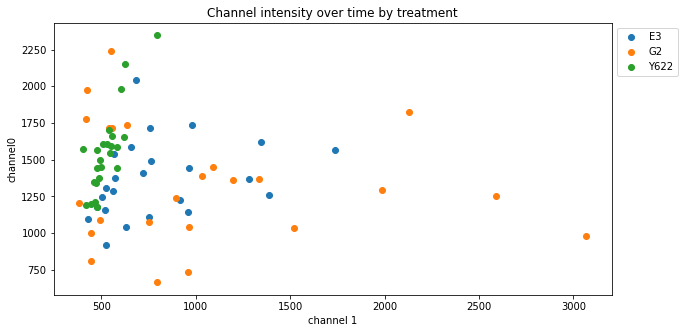

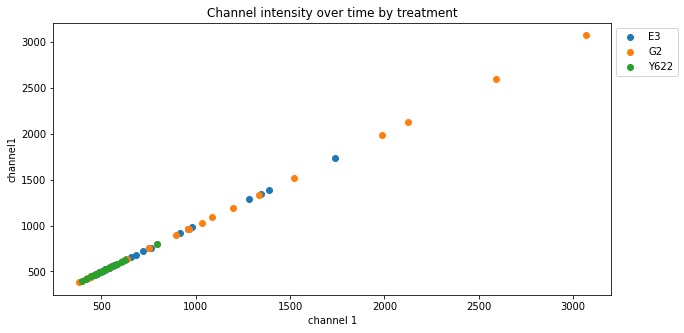

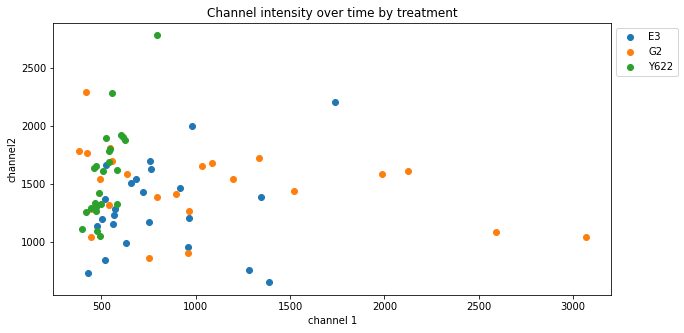

In [9]:
N = 3
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines, means[:,1], means[:,x].reshape(-1), xlab='channel 1', ylab='channel' + str(x))
    plt.title('Channel intensity over time by treatment')
    

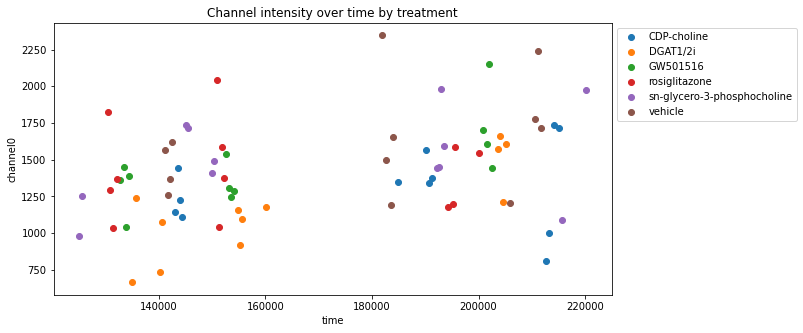

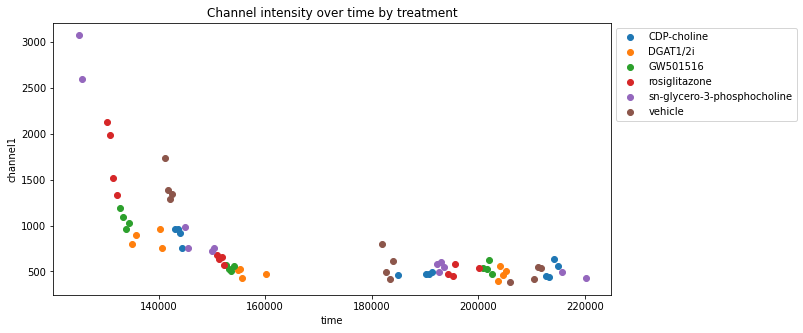

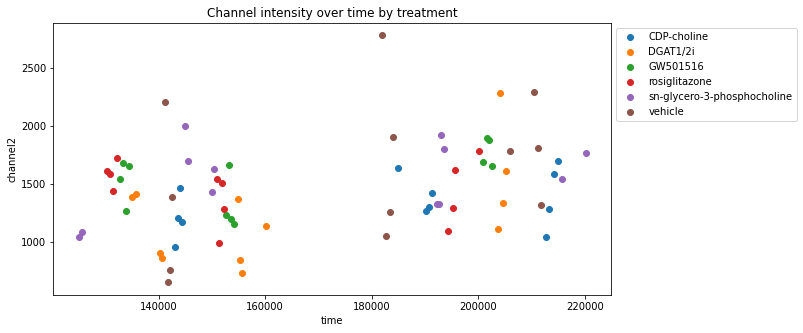

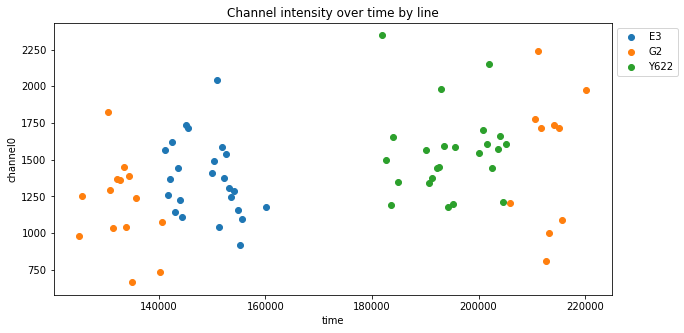

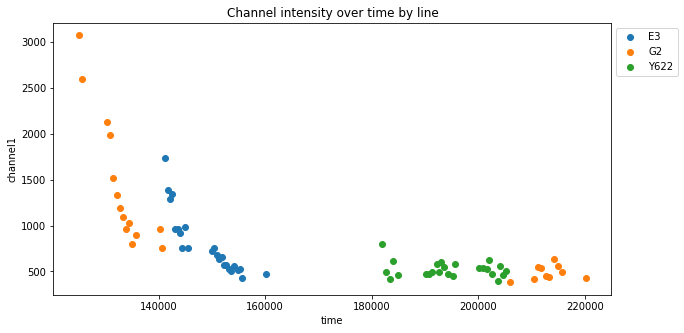

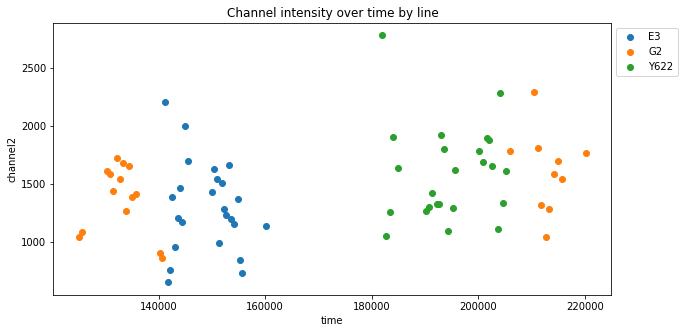

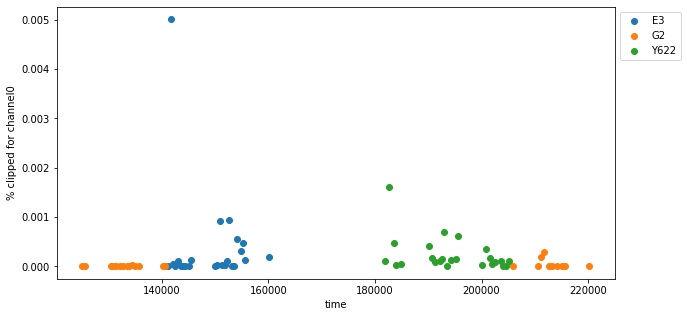

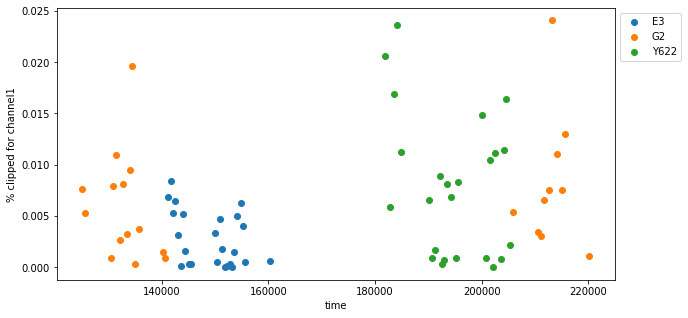

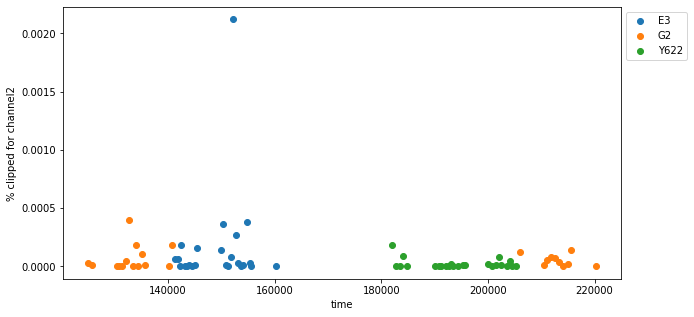

In [10]:
# plot dists by condition
day, time = get_day_and_time(df)
N = 3
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(treat, time, means[:,x].reshape(-1), xlab='time', ylab='channel' + str(x))
    plt.title('Channel intensity over time by treatment')
    
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines, time, means[:,x].reshape(-1), xlab='time', ylab='channel' + str(x))
    plt.title('Channel intensity over time by line')

for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines, time, out_percent_clipped[:,x].reshape(-1), xlab='time', ylab='% clipped for channel' + str(x))


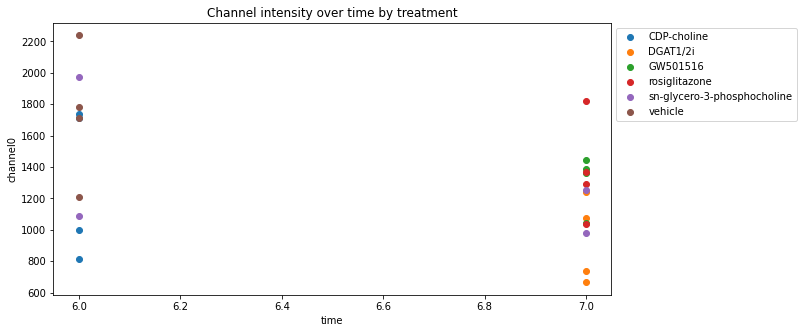

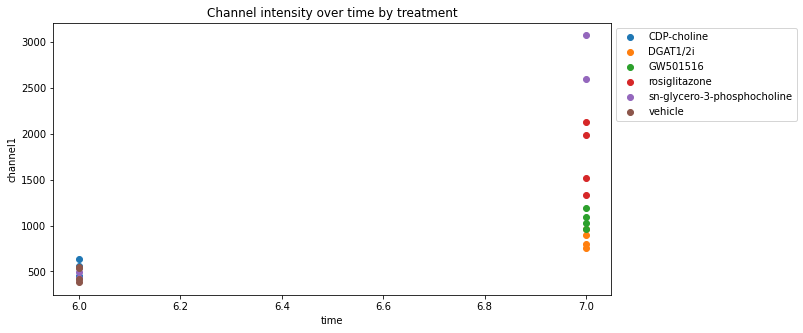

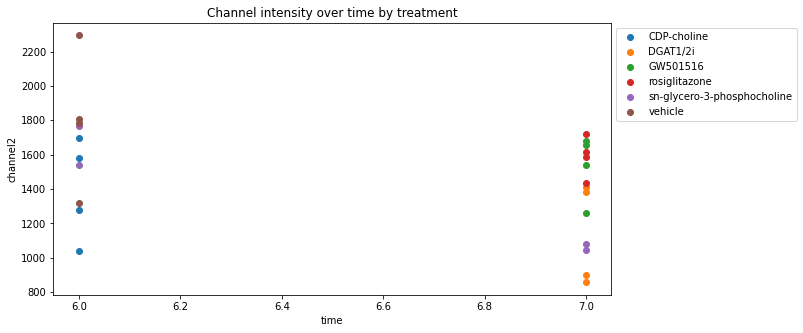

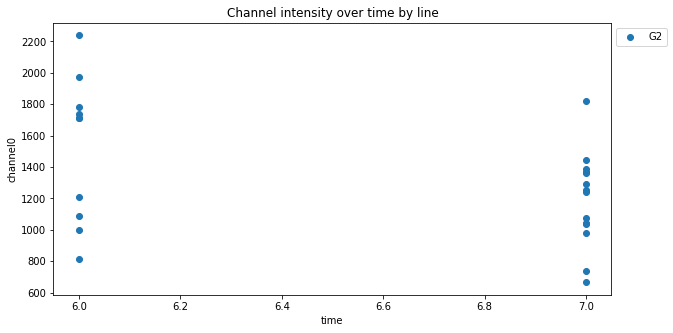

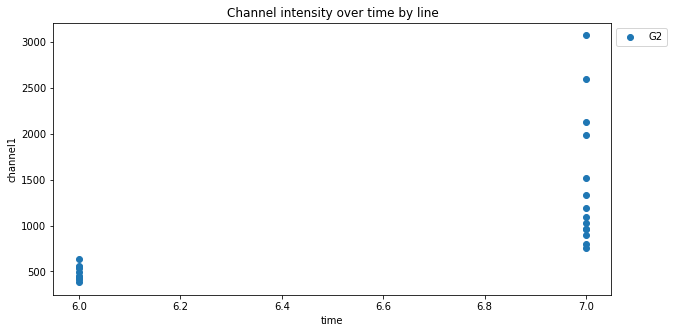

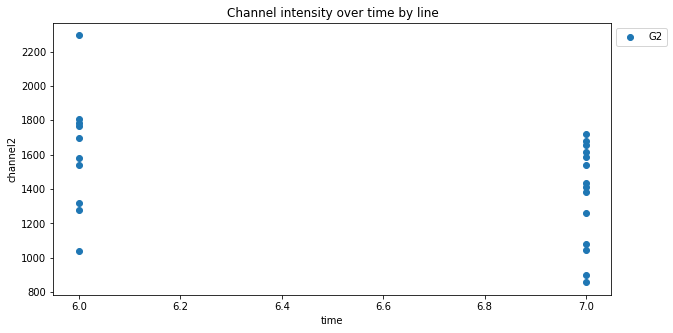

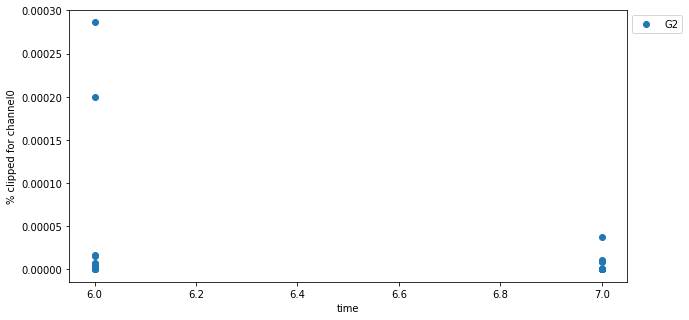

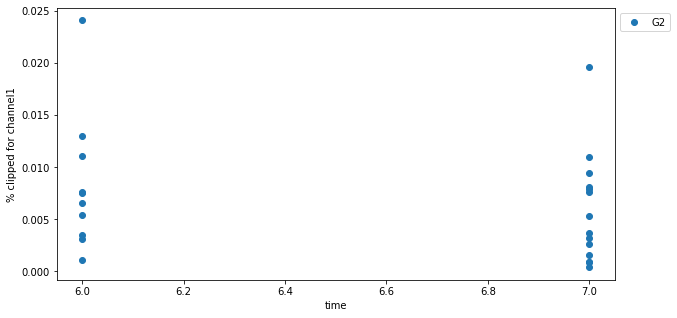

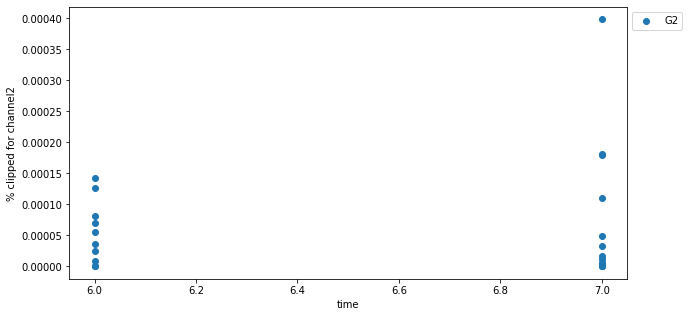

In [11]:
# plot dists by condition
index = np.array(lines)=='G2'
N = 3
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(treat[index], day[index], means[index,x].reshape(-1), xlab='time', ylab='channel' + str(x))
    plt.title('Channel intensity over time by treatment')
    
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines[index], day[index], means[index,x].reshape(-1), xlab='time', ylab='channel' + str(x))
    plt.title('Channel intensity over time by line')

for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines[index], day[index], out_percent_clipped[index,x].reshape(-1), xlab='time', ylab='% clipped for channel' + str(x))


Text(0.5, 1.0, 'correlation of channel means?')

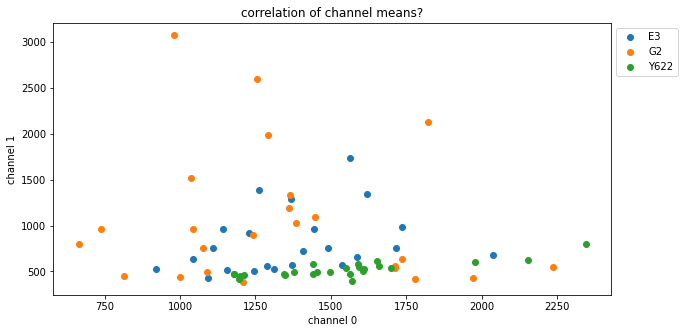

In [12]:
plt.figure(figsize=(10,5))
plot_by(lines, means[:,0], means[:,1], xlab='channel 0', ylab='channel 1')
plt.title('correlation of channel means?')

Text(0.5, 1.0, 'correlation with pinhole diameter?')

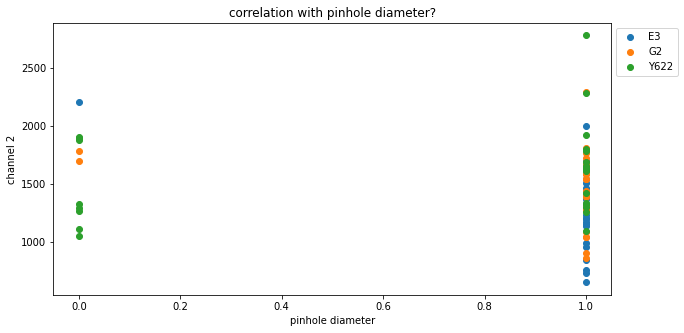

In [13]:
plt.figure(figsize=(10,5))
pinhole_diam = [x[-1]=='24.510611861372' for x in df['MTBLSMPinholeDiameter']]
plot_by(lines, np.array(pinhole_diam), means[:,2], xlab='pinhole diameter', ylab='channel 2')
plt.title('correlation with pinhole diameter?')

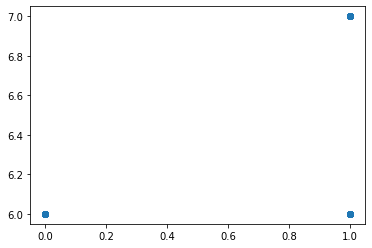

In [14]:
plt.scatter(np.array(pinhole_diam), day)

In [15]:
# toggle segmentations
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results('./outs/neuronbatch11082023_mitohealth_out/run_jobs_110823_mito.sbatch', '')

In [30]:
# choose IDs
id1 = 7481970912
id2 = 5588342975
index1 = np.argwhere([x[0]==id1 for x in randID_per_job])[0][0]
index2 = np.argwhere([x[0]==id2 for x in randID_per_job])[0][0]

In [32]:
print(index1)
print(index2)

51
11


In [33]:
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####

toggle_filters([files[51],files[11]], parent, [0,1,2]) #index1], files[index2]


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


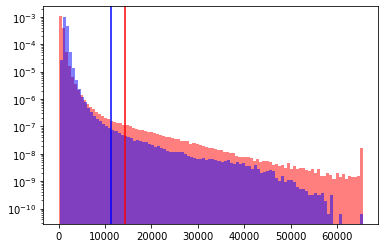

In [55]:
# look at clipping & histograms for select images (especially for a few differentially bright images)
plot_hist(parent + files[2], 1, 100, True, .5, color='red', density=True)
plot_hist(parent + files[8], 1, 100, True,.5, color='blue', density=True)
plt.axvline(x = x, color='red')
plt.axvline(x = y, color='blue')

#plt.xlim(0,10000)

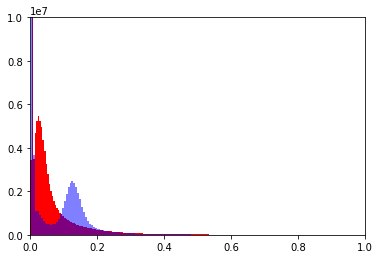

In [79]:
img = AICSImage(parent+files[2])
img2 = AICSImage(parent+files[8])
x = np.percentile(img.data, 99.9)
y = np.percentile(img2.data, 99.9)

plt.hist((img.data/x).ravel(), 1000, color='red')
plt.hist((img2.data/y).ravel(), 1000, color='blue', alpha=.5)
plt.xlim(0,1)
plt.ylim(0,1e7)
None

In [16]:
# toggle segmentation
val = 1
out_seg = []
for i in tqdm(range(len(files))): #
    out_seg.append(impose_segmentation_all(i, zi_per_job, Nzi_per_job, all_mat, all_masks, val))

100%|██████████| 72/72 [02:55<00:00,  2.44s/it]


In [19]:
randID_per_job[2]

memmap([1794921487])

In [17]:
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####

toggle_filters(files, parent, [0,1,2], out_seg) #index1], files[index2]


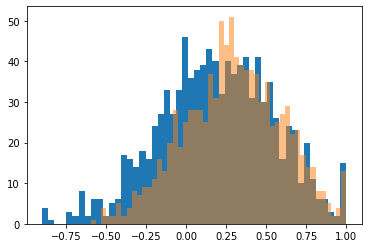

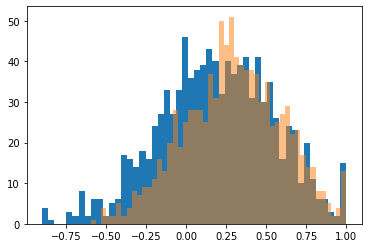

In [29]:
d1_clip = np.clip(d1/np.percentile(d1, 99), a_min = np.min(d1), a_max = 1)
d2_clip = np.clip(d2/np.percentile(d2, 99), a_min = np.min(d2), a_max = 1)

#plt.hist(d1)
plt.hist(d1_clip, 50)
plt.hist(d2_clip, 50,alpha=.5)

None

plt.figure()
d1_clip = d1.copy()
d1_clip[d1_clip>=np.percentile(d1, 99)]=np.percentile(d1, 99)

d2_clip = d2.copy()
d2_clip[d2_clip>=np.percentile(d2, 99)]=np.percentile(d2, 99)

#plt.hist(d1)
plt.hist(d1_clip/np.max(d1_clip), 50)
plt.hist(d2_clip/np.max(d2_clip), 50, alpha=.5)

None

In [192]:
channels = [0,1,2]
channel_names = ['DAPI', 'NeuN', 'Mito']
resE = []
resV = []
resN = []

for ID in tqdm(range(len(files))):
    start = ID*zi_per_job
    end = start + Nzi_per_job[ID][0]
    
    probs_sele = probs[start:end].ravel()
    masks_sele = all_masks[start:end].ravel()
    out_float_sele = all_mat[start:end]
    
    M_unique = np.unique(masks_sele)
    NM = len(M_unique)
    
    outputs_E = np.empty((NM, len(channels)))
    outputs_V = np.empty((NM, len(channels)))
    outputs_N = np.empty((NM, len(channels)))

    E = np.empty(NM)
    V = np.empty(NM)
    N = np.empty(NM)
    
    for C in channels:
        vals_sele = out_float_sele[:,:,:,C].ravel()
        get_expectations(NM, masks_sele, probs_sele, vals_sele, E, V, N)
        outputs_E[:,C] = E
        outputs_V[:,C] = V
        outputs_N[:,C] = N

    df_E = pd.DataFrame(outputs_E[1:])
    df_E.columns = ['channel_' + str(i) for i in channel_names]
    df_E['ID'] = ID
    df_E['file'] = files[ID]
    df_E['line'] = lines[ID]
    df_E['treatment'] = treat[ID]

    df_V = pd.DataFrame(outputs_V[1:])
    df_V.columns = ['channel_' + str(i) for i in channel_names]
    df_V['ID'] = ID
    df_V['file'] = files[ID]
    df_V['line'] = lines[ID]
    df_V['treatment'] = treat[ID]
    
    df_N = pd.DataFrame(outputs_N[1:])
    
    resE.append(df_E)
    resV.append(df_V)
    resN.append(df_N)

100%|██████████| 72/72 [10:54<00:00,  9.10s/it]


In [86]:
lines[:30]

array(['E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3',
       'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'Y622',
       'Y622', 'Y622', 'Y622', 'Y622', 'Y622', 'Y622', 'Y622', 'Y622',
       'Y622'], dtype='<U4')

In [193]:
# concatenate the results

resE = pd.concat(resE)
resE['well'] = [x.split('-')[0] for x in resE['file']]
resE.index = range(resE.shape[0])

resV = pd.concat(resV)
resV['well'] = [x.split('-')[0] for x in resV['file']]
resV.index = range(resV.shape[0])

In [199]:
resN = pd.concat(resN)
resN.index = range(resN.shape[0])
resE['size'] = resN[0]

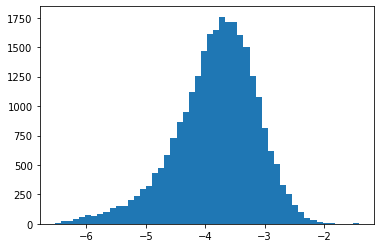

In [24]:
plt.hist(np.log(resV['channel_Mito']),50)
None

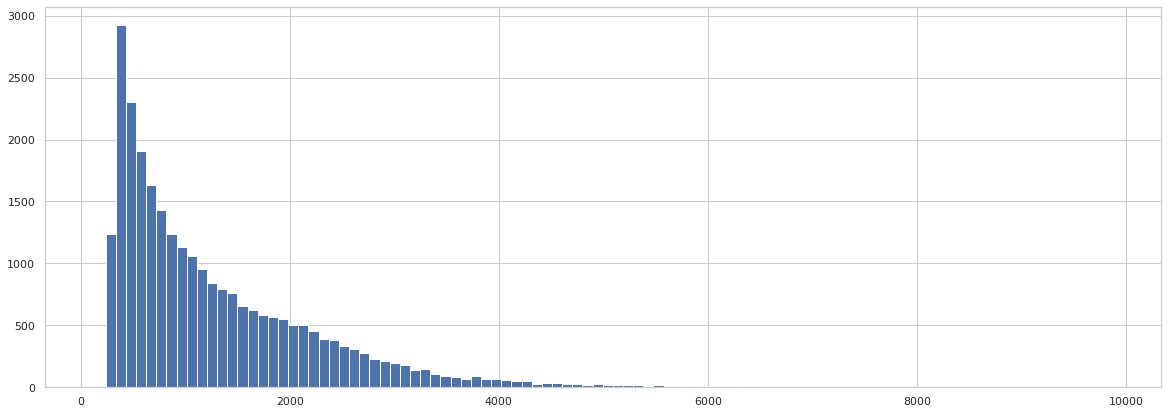

In [202]:
plt.hist((resE['size']),100)
None

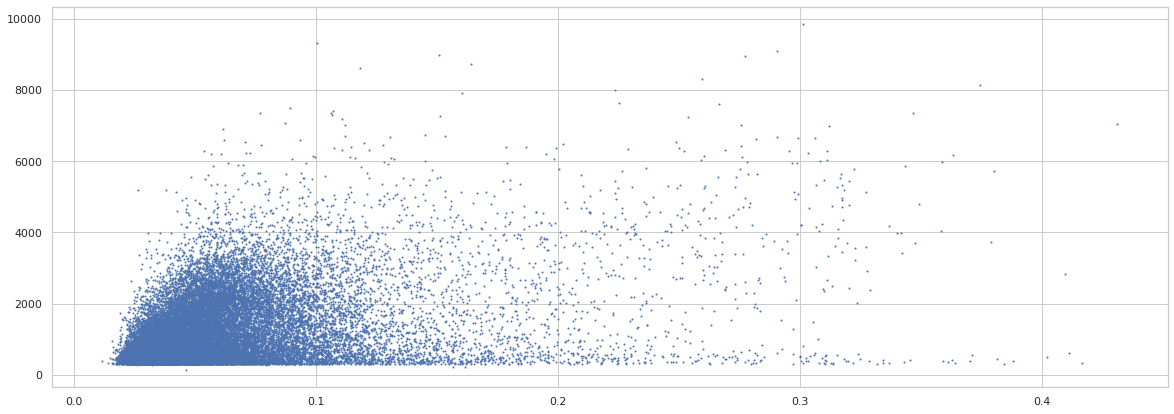

In [206]:
plt.scatter(resE['channel_NeuN'],resE['size'],  s=1)

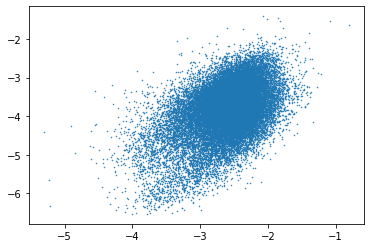

In [36]:
#plt.scatter((resE['channel_DAPI']), (resV['channel_DAPI']))
plt.scatter(np.log(resE['channel_Mito']), np.log(resV['channel_Mito']),.25)

In [ ]:
# get rid of the low DAPI population

In [207]:
from sklearn.mixture import GaussianMixture

# Extract the first two columns for GMM
gmm_data = resE[['channel_DAPI']]

# Define the range of components to try
n_components_range = range(1, 6)

# Fit GMMs with different numbers of components
bics = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(gmm_data)
    bics.append(gmm.bic(gmm_data))

# Find the optimal number of components (lowest BIC)
optimal_n_components = n_components_range[bics.index(min(bics))]

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_n_components, random_state=5, max_iter=1000)
gmm.fit(gmm_data)

# Predict the labels
labels = gmm.predict(gmm_data)
gmm_data['gmm_label'] = labels

# Add the labels to the DataFrame
resE['gmm_label'] = labels


/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/2530637508.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmm_data['gmm_label'] = labels


<Axes: xlabel='channel_DAPI', ylabel='Count'>

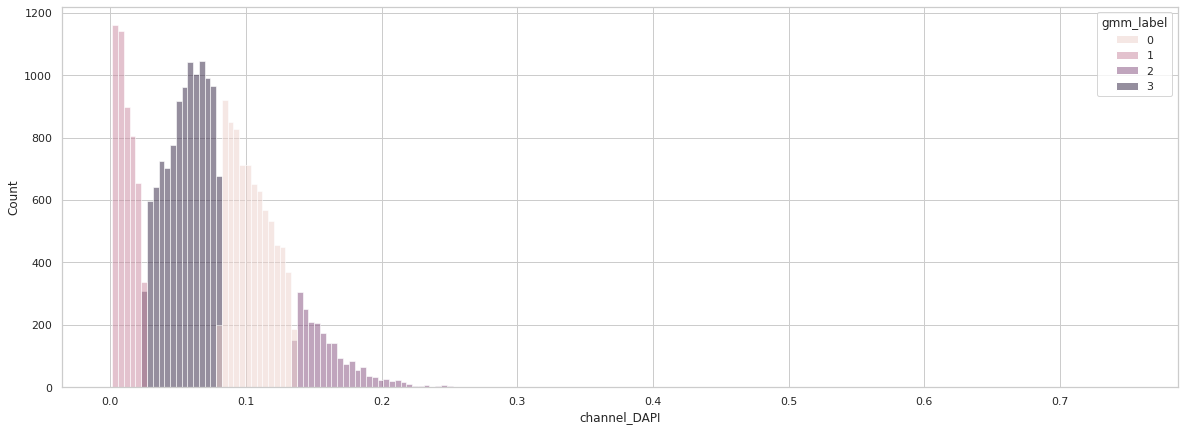

In [208]:
sns.histplot(data=resE, x='channel_DAPI', hue = 'gmm_label')


<Axes: xlabel='log_DAPI', ylabel='log_NeuN'>

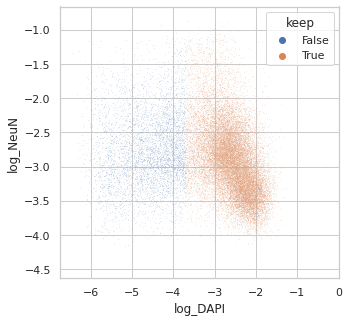

In [209]:
resE['log_DAPI'] = np.log(resE['channel_DAPI'])
resE['log_NeuN'] = np.log(resE['channel_NeuN'])
resE['keep'] = resE['gmm_label']!=1
plt.figure(figsize=(5,5))
sns.scatterplot(data=resE, x=('log_DAPI'), y = ('log_NeuN'), hue = 'keep', s=.2)

In [210]:
np.unique(resE['keep'], return_counts=True)

(array([False,  True]), array([ 4997, 21612]))

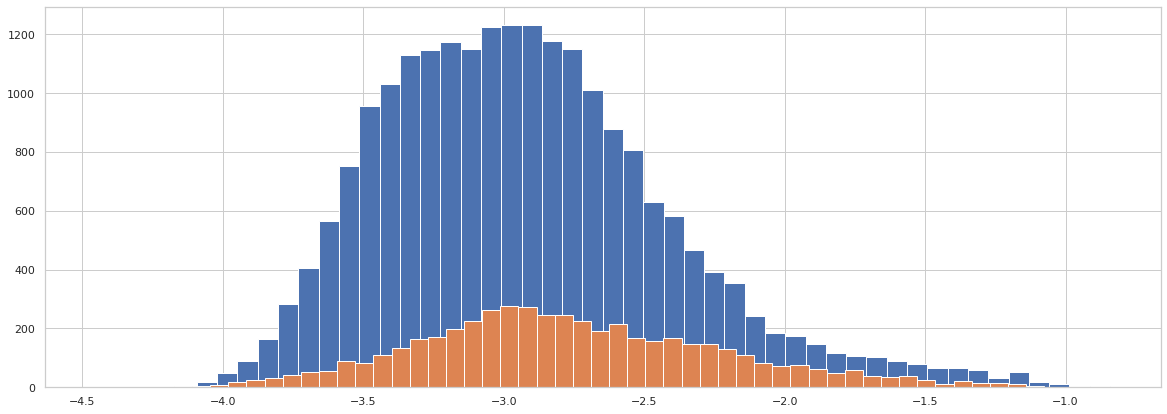

In [211]:
plt.hist(np.log(resE['channel_NeuN'][resE['keep']]), 50)
plt.hist(np.log(resE['channel_NeuN'][np.invert(resE['keep'])]), 50)
None

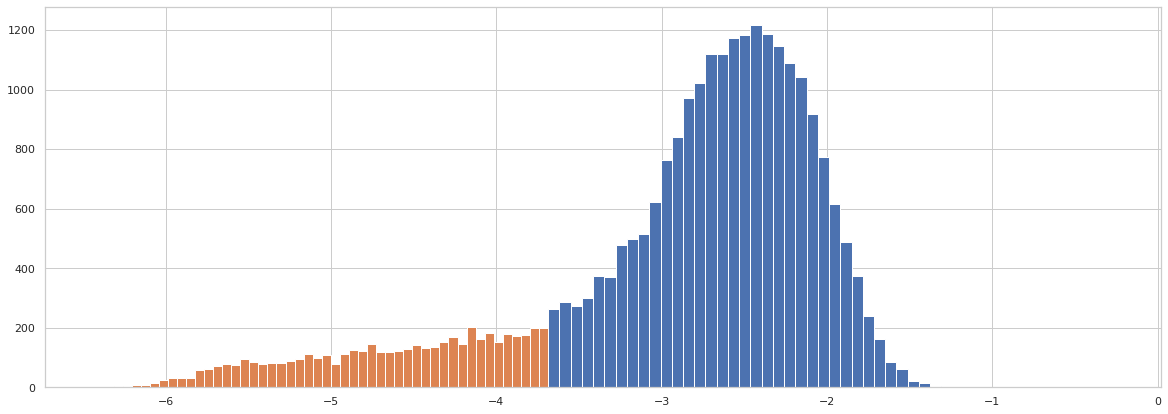

In [212]:
plt.hist(np.log(resE['channel_DAPI'][resE['keep']]), 50)
plt.hist(np.log(resE['channel_DAPI'][np.invert(resE['keep'])]), 50)
None

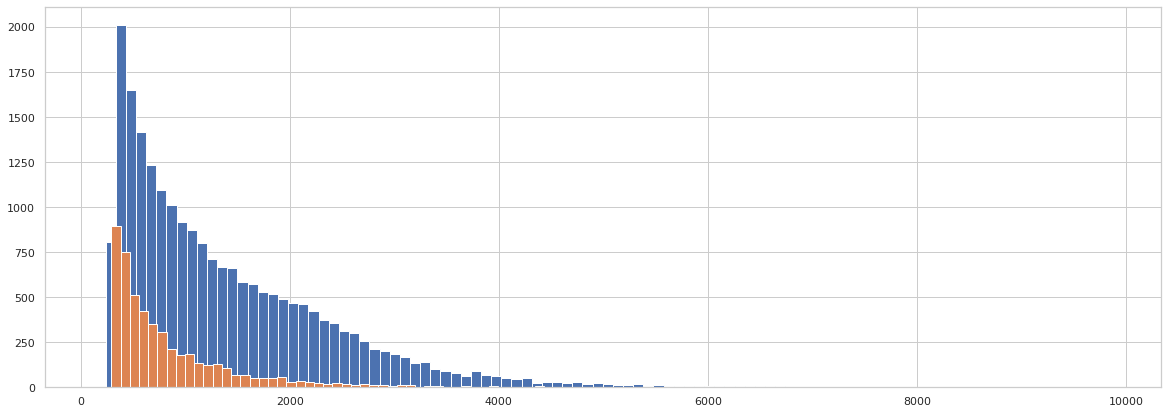

In [215]:
plt.hist((resE['size'][resE['keep']]), 100)
plt.hist((resE['size'][np.invert(resE['keep'])]), 100)
None

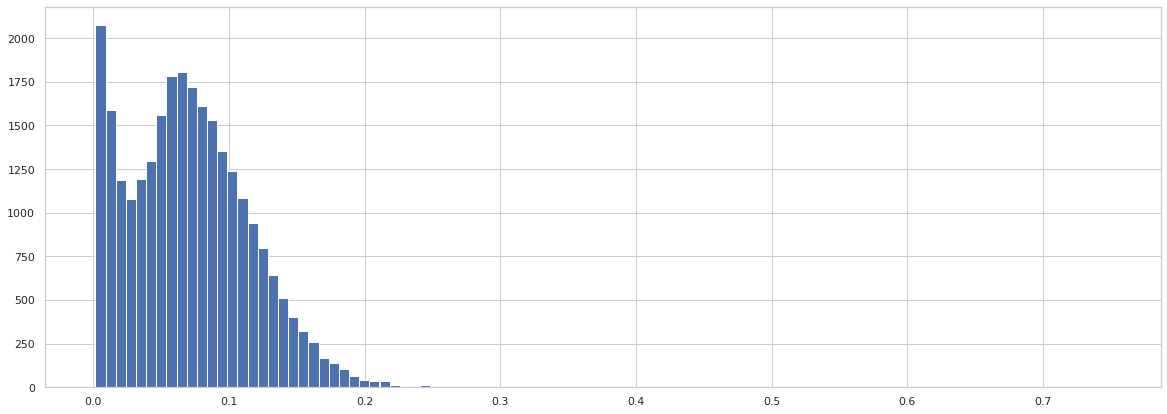

In [119]:
plt.hist((resE['channel_DAPI']), 100)
None

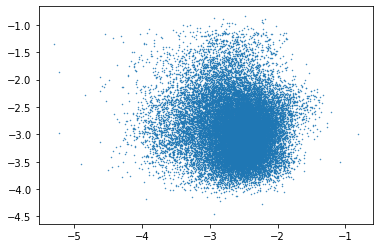

In [28]:
plt.scatter(np.log(resE['channel_Mito']), np.log(resE['channel_NeuN']),.2)

In [29]:
resE.head()

,channel_DAPI,channel_NeuN,channel_Mito,ID,file,line,treatment,well
0,0.032604,0.299058,0.034577,0,B03-1.czi,E3,vehicle,B03
1,0.049524,0.154119,0.033854,0,B03-1.czi,E3,vehicle,B03
2,0.033930,0.224297,0.026378,0,B03-1.czi,E3,vehicle,B03
3,0.058350,0.171283,0.028478,0,B03-1.czi,E3,vehicle,B03
4,0.050914,0.139500,0.030422,0,B03-1.czi,E3,vehicle,B03


/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/1629877405.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() 

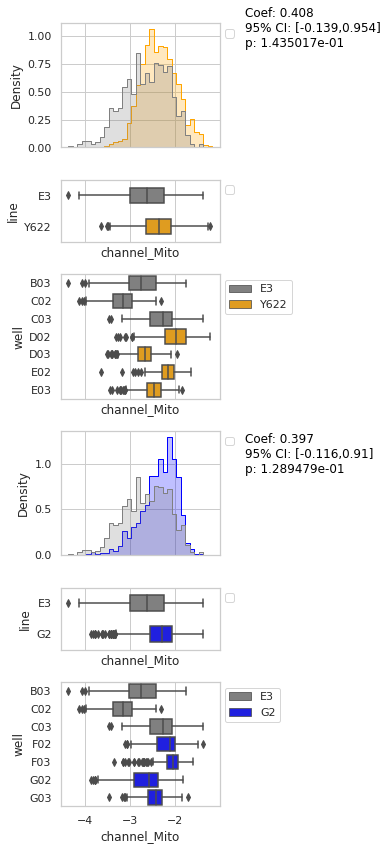

In [228]:
# plot lines
colors = dict(zip(np.unique(resE['line']), ['grey', 'blue', 'orange']))
plot_lines(resE[resE['keep']], 'channel_Mito', 'vehicle', colors, True, .1)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_mito_line.pdf')

/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/1629877405.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


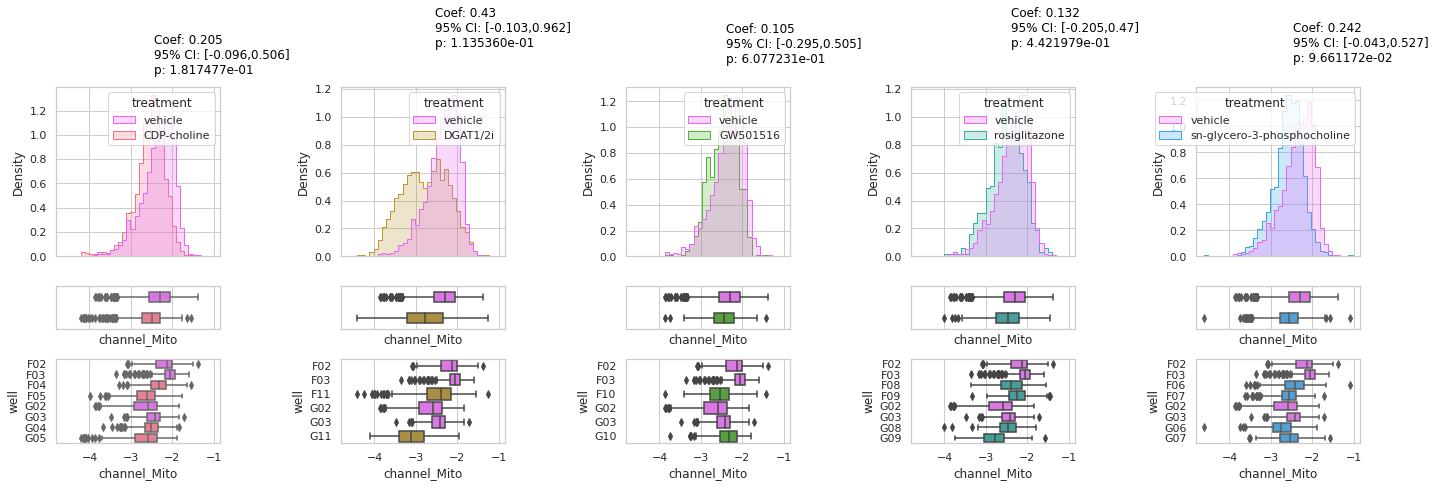

In [229]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE[resE['keep']], 'channel_Mito', 'G2', colors, True, 0.1, 1.5)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/1629877405.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


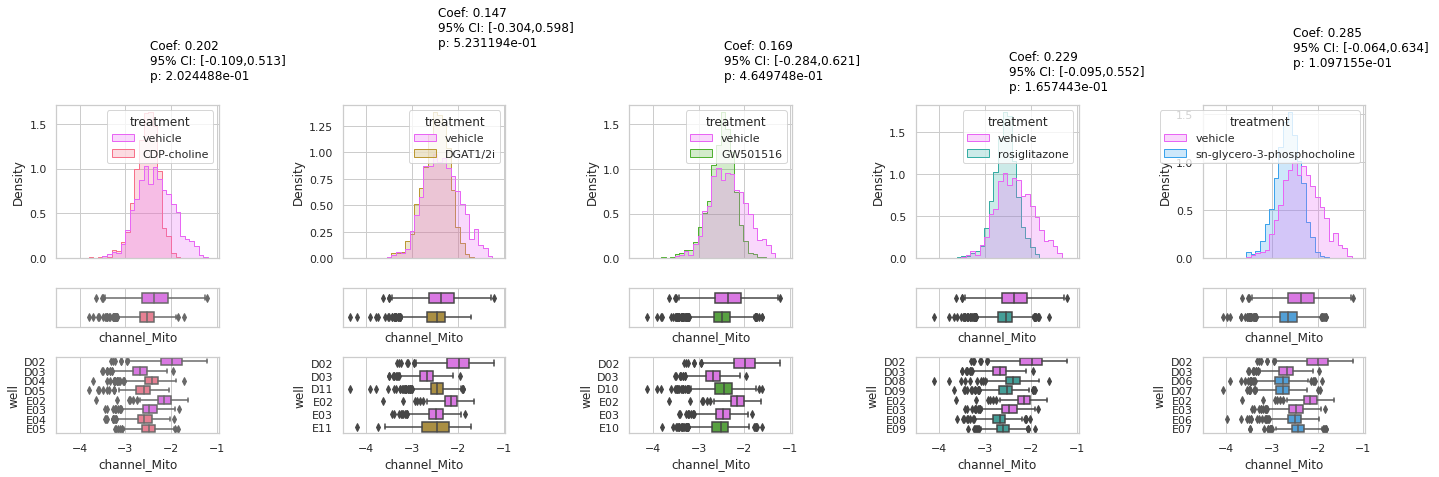

In [230]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE[resE['keep']], 'channel_Mito', 'Y622', colors, True, 0.1, lab_height=2)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_mito_Y622_treat.pdf')

/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/1629877405.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


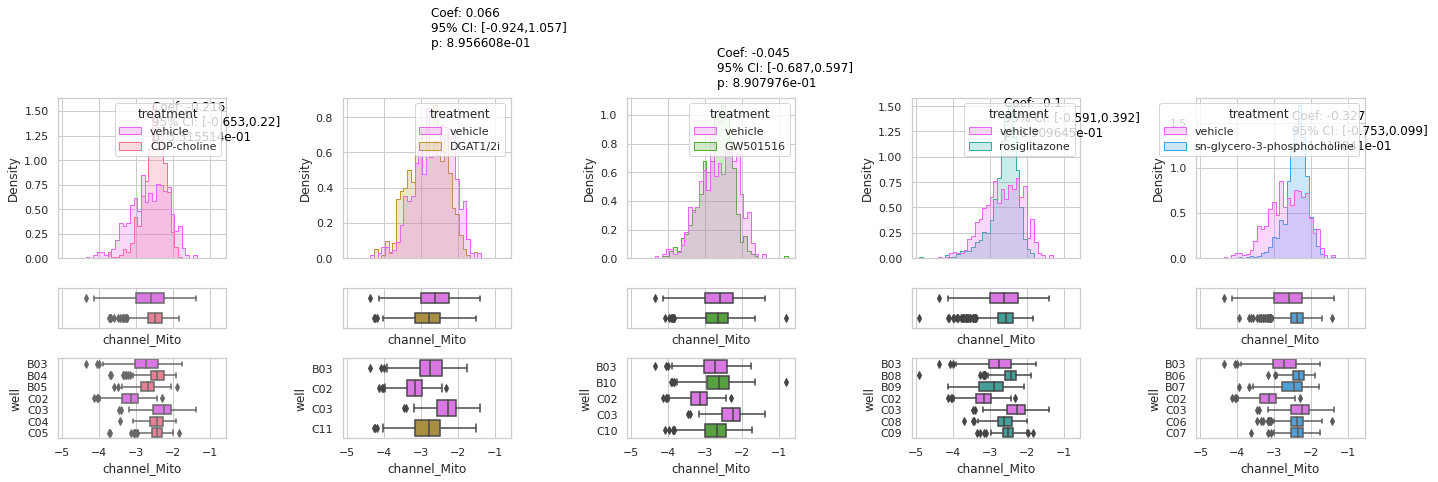

In [232]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE[resE['keep']], 'channel_Mito', 'E3', colors, True, 0.1, lab_height=1.2)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_mito_E3_treat.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1104951/4001088939.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


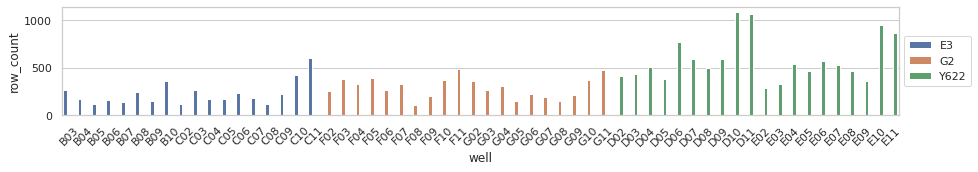

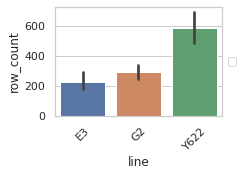

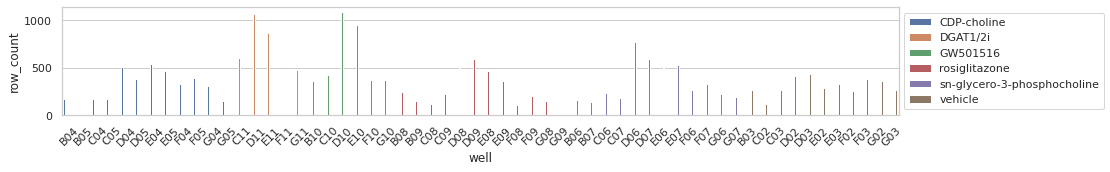

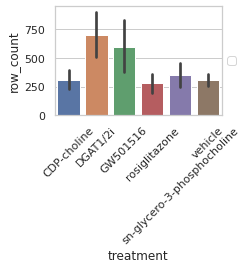

In [233]:
# sanity check cell numbers

row_counts = resE[resE['keep']].groupby(['line', 'well']).size().reset_index(name='row_count')
plt.figure(figsize=(15,2))
sns.barplot(data=row_counts, x='well', y='row_count', hue='line')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(3,2))
sns.barplot(data=row_counts, x='line', y='row_count')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

row_counts = resE[resE['keep']].groupby(['treatment', 'well']).size().reset_index(name='row_count')
plt.figure(figsize=(15,2))
sns.barplot(data=row_counts, x='well', y='row_count', hue='treatment')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(3,2))
sns.barplot(data=row_counts, x='treatment', y='row_count')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_mito_N.pdf')

In [32]:
# show rep images

In [65]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int, hide_masks
from confocalQuant.plotting import add_scale_bar, add_inset, plot_axis, get_id_data, get_mean_projections, compute_avs, get_rep_im
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage

In [66]:
# get rep images
treatments = np.unique(resE['treatment'])
dict_treat = dict(zip(resE['file'], resE['treatment']))
dict_line = dict(zip(resE['file'], resE['line']))

mean_per_filename, mean_per_condition = compute_avs(resE, 'file', 'treatment', 'line', 'channel_NeuN')

rep = []
for i in treatments:
    rep.append(get_rep_im(i, 'E3', files, mean_per_condition, mean_per_filename, dict_treat, dict_line))

In [71]:
e3_rep = get_rep_im('vehicle', 'E3', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
y622_rep = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
g2_rep = get_rep_im('vehicle', 'G2', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [73]:
y622_rep

36

In [74]:
# define column names
collabs = ['NeuN','NeuN+DAPI',  'NeuN Mask', 'Mito']
rowlabs = ['E3', 'Y622', 'G2']

In [75]:
rep = [e3_rep, y622_rep, g2_rep]

In [97]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mat_sele, mask_sele = get_id_data(i, zi_per_job, Nzi_per_job, all_mat, all_masks)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)

nums = [90, 95, 99]
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))
lower_dict = {0: 0, 1: 0, 2: 0}
gamma_dict = {0: 1, 1: 1, 2: 1}
background_dict = {0: 0, 1: 99, 2: 0}
percentile=False

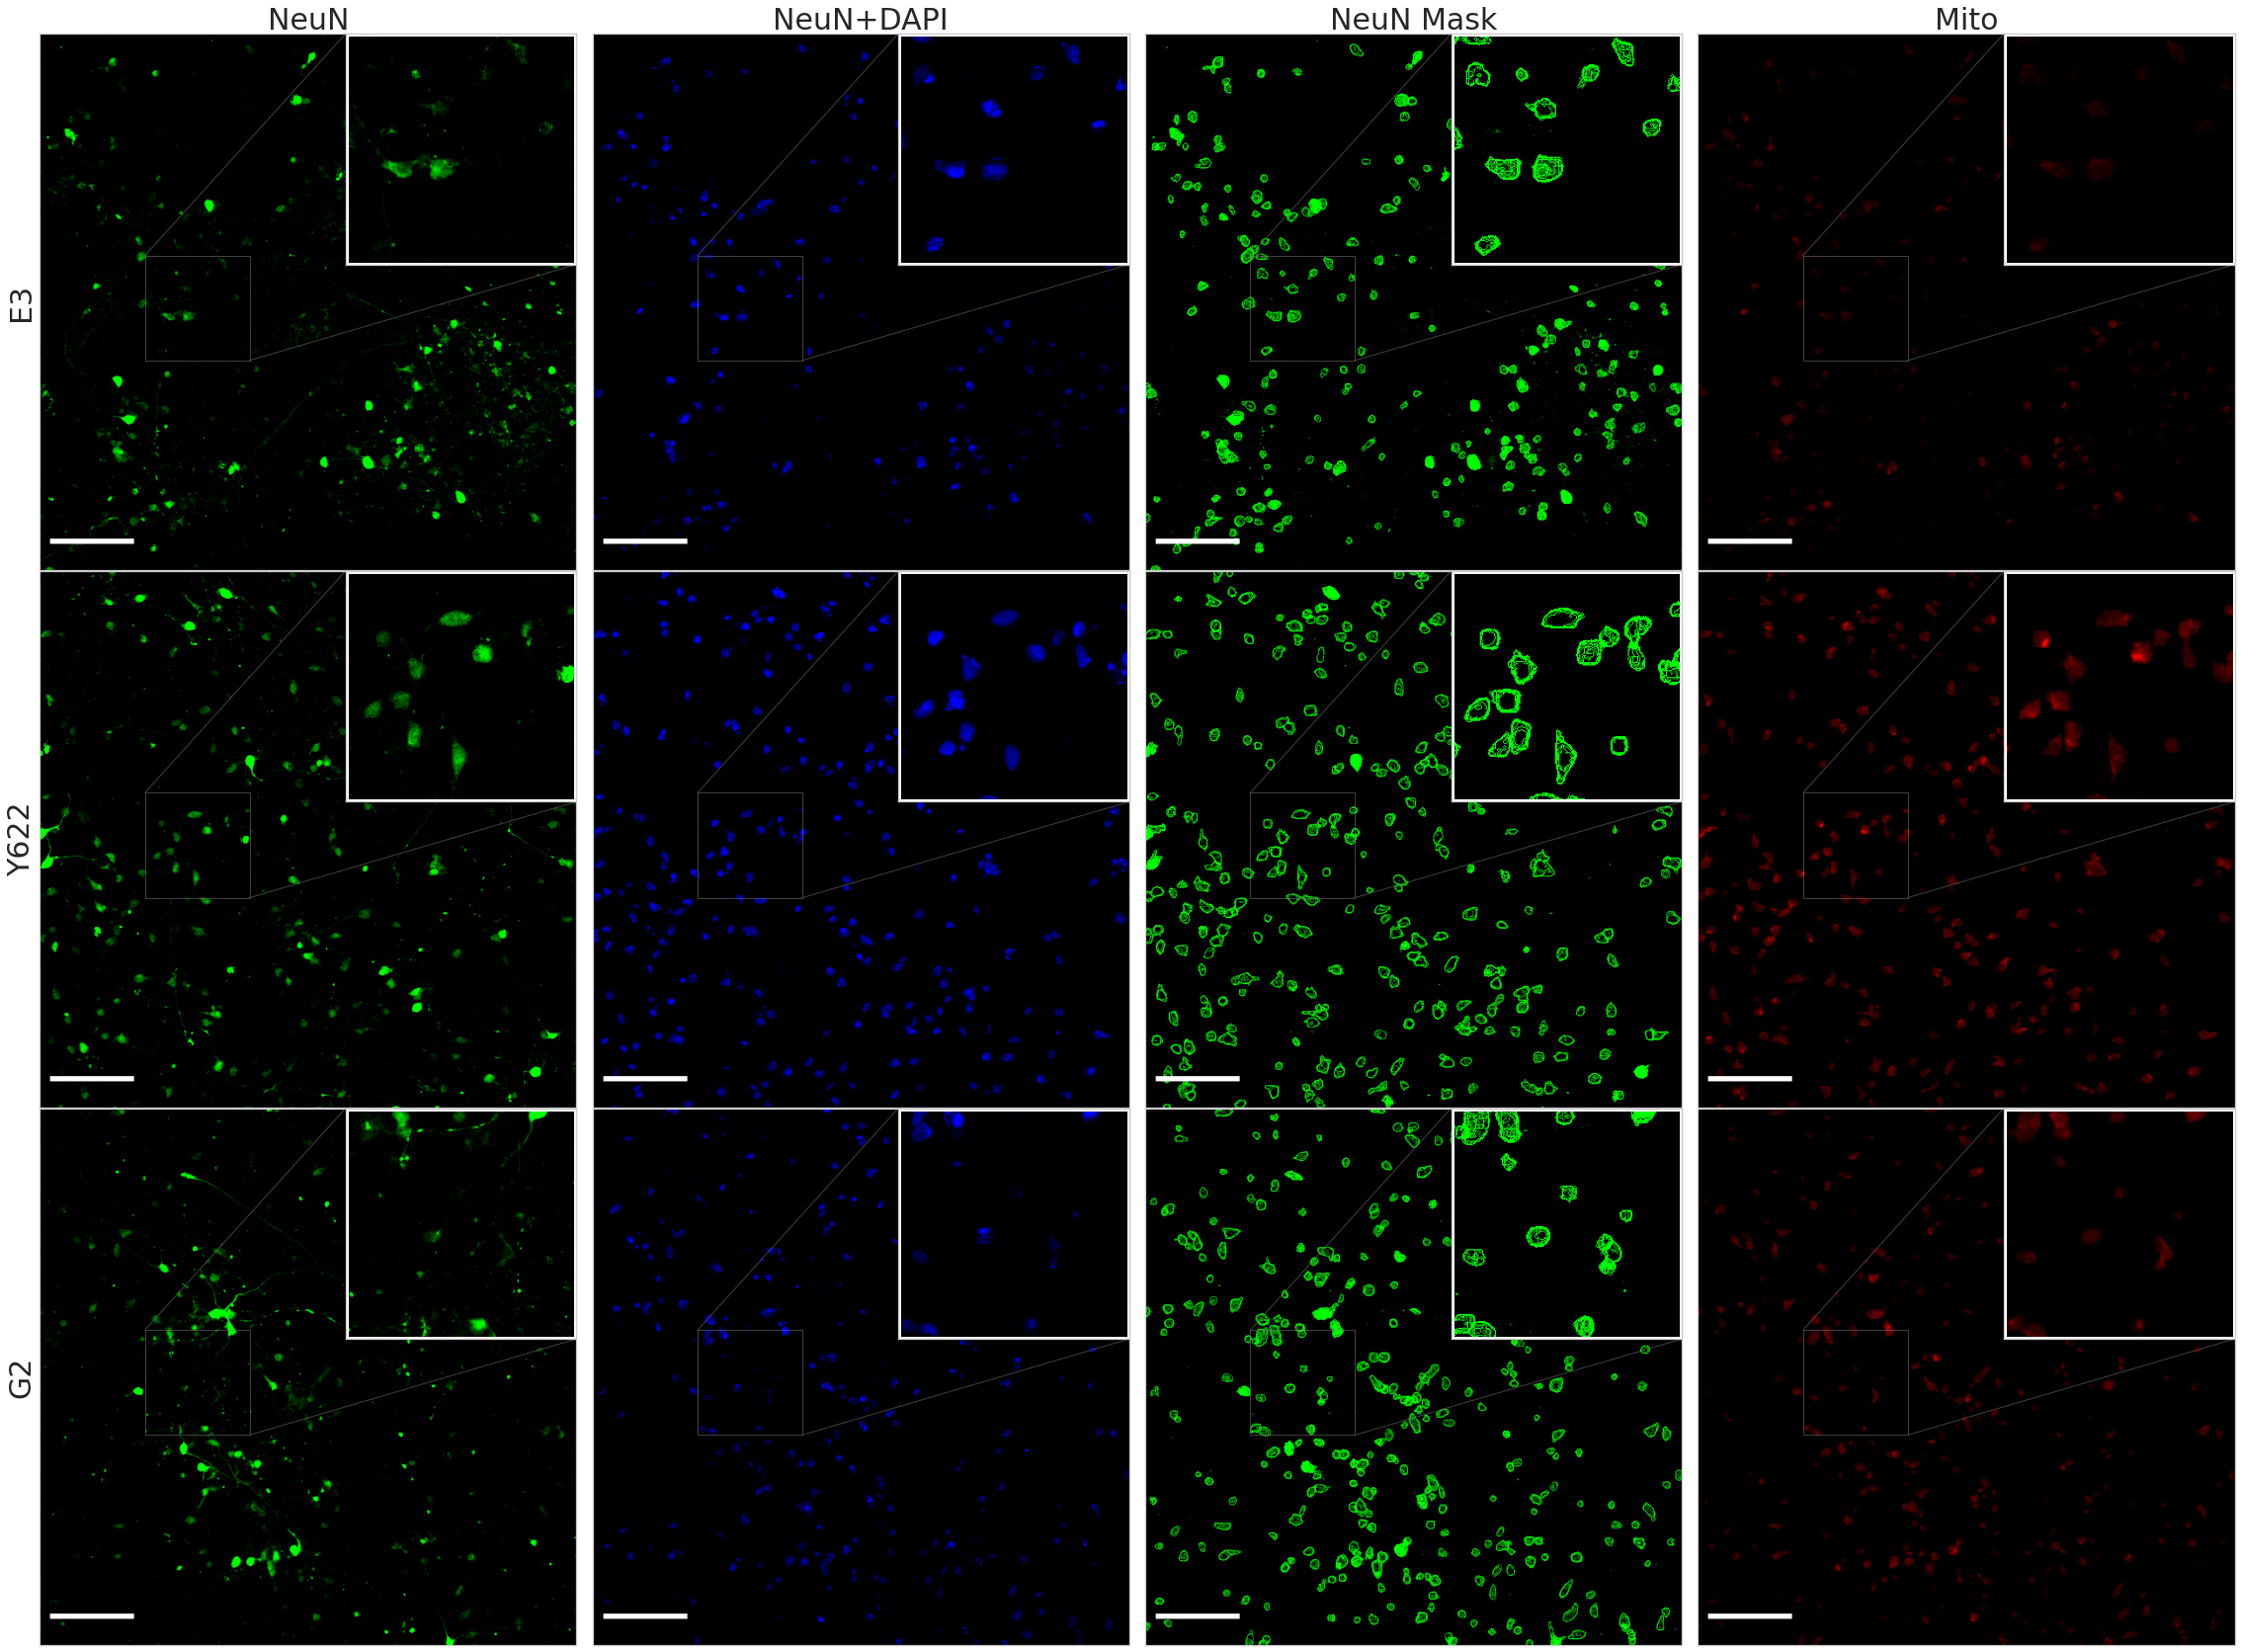

In [235]:
# show images
conditions = rep
fig, axes = plt.subplots(3, 4, figsize=(40, 30))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.001, wspace=0.01)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi_per_job, all_mat, all_masks)
    
    # make plots
    plt0 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[0], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    d = impose_segmentation(mask_sele, mat_sele, val=1)
    plt2 = get_mean_projections(d, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)

    # get image
    imgA = AICSImage(parent + files[ID])

    # show plots
    plot_axis(axes, plt3, i,0, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,0, plt3)

    plot_axis(axes, plt0, i,1, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,1, plt0)
    
    plot_axis(axes, plt2, i,2, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,2, plt2)

    plot_axis(axes, plt1, i,3, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,3, plt1)
    


fig.savefig('./outs/all_outs/plots/1108_mito_rep.png')


In [ ]:
# size filter?